In [14]:
!pip install -q langchain-community faiss-cpu networkx

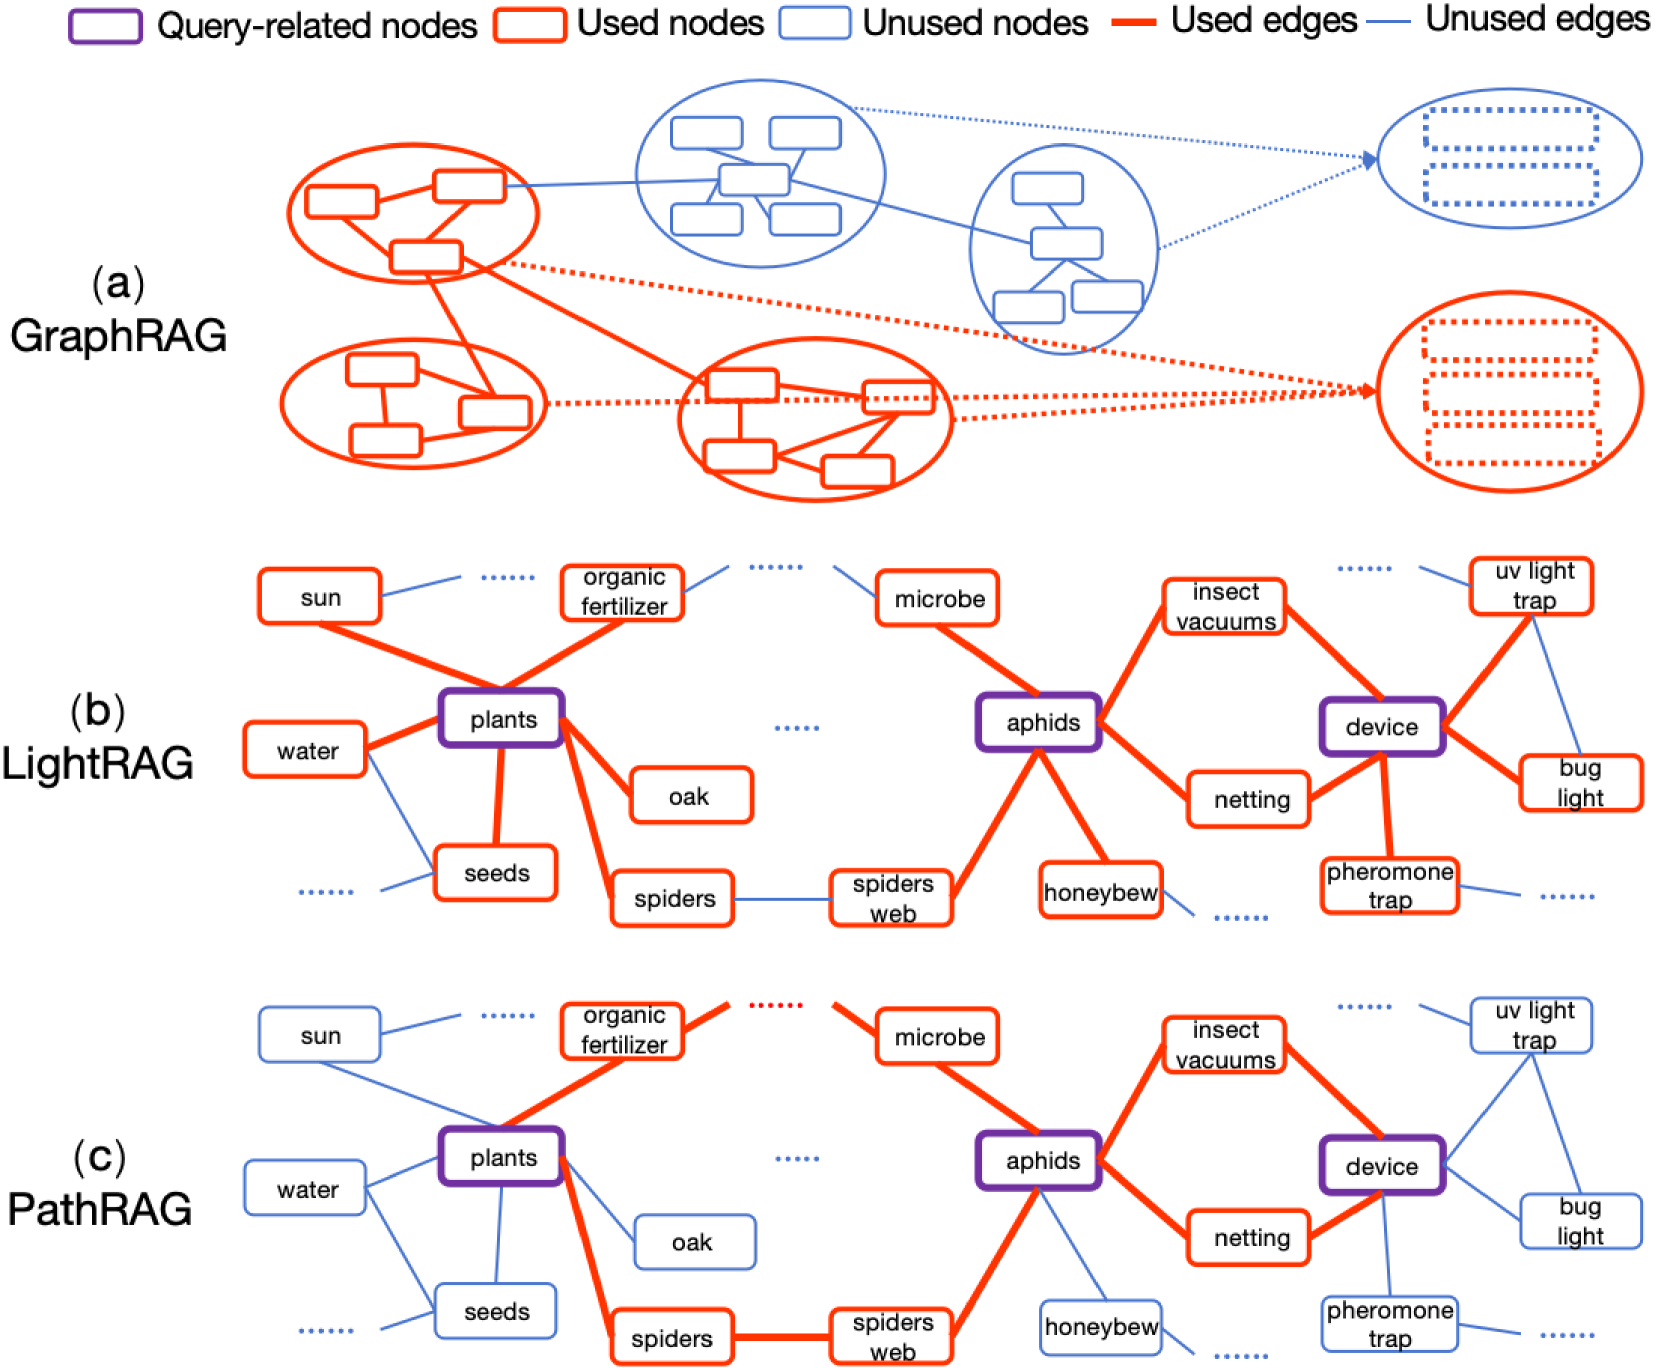

## 🔍 **PathRAG: Enhancing Graph-Based RAG with Path-Based Prompting**

* **Problem Addressed**:

  * Traditional RAG systems organize documents in a **flat chunk structure**, missing deeper **semantic relationships**.
  * **Graph-based RAG** improves structure but suffers from **redundant retrieval** and **inefficient prompt construction**.

* **Key Limitations in Existing Graph-RAG**:

  * **Redundant information** in retrieval rather than insufficient information.
  * Retrieved data is organized **flatly in prompts**, reducing coherence and response quality.

* **Proposed Solution – PathRAG**:

  * Constructs an **indexing graph** to represent structured relationships.
  * **Retrieves key relational paths** rather than all connected chunks.
  * Converts paths into **textual form** for effective **LLM prompting**.

* **Techniques Introduced**:

  * **Flow-based pruning**: Removes redundant paths, keeping only informative relationships.
  * **Path-based prompting**: Presents retrieved paths in a logical order, guiding LLMs for better generation.

* **Results**:

  * Outperforms state-of-the-art RAG methods across:

    * **6 benchmark datasets**
    * **5 evaluation metrics/dimensions**
  * Demonstrates superior **logical consistency** and **response quality**.

* **Code Repository**:

  * 🧠 [GitHub – PathRAG](https://github.com/BUPT-GAMMA/PathRAG)

---

## 📄 Traditional RAG – Flat Chunk Structure

### 🔍 Description

In traditional Retrieval-Augmented Generation (RAG), documents are split into **independent, fixed-size text chunks**, typically without considering their **semantic or structural relationships** (e.g., chapter titles, paragraph context, or logical flow). These chunks are then embedded individually and stored in a **vector database** for retrieval.

This **flat structure** has the following characteristics:

* ❌ **No awareness of relationships** between chunks (e.g., cause-effect, topic hierarchy).
* ✅ **Fast to index and search**, but lacks context-awareness.
* ⚠️ Can lead to **retrieving multiple redundant chunks**, or missing important dependencies.

This simplicity is a trade-off between **efficiency** and **expressiveness**.

---

# 🧪 Python Example: Flat Chunking and Embedding

In [15]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Sample document
document = """
Canada is a country in North America. It has ten provinces and three territories.
Ottawa is the capital city of Canada. The country is known for its natural beauty.
"""

# 1. Chunking the document (flat, no hierarchy)
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=50,
    chunk_overlap=0
)
chunks = text_splitter.split_text(document)

# 2. Load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 3. Create FAISS index (vector store)
vectorstore = FAISS.from_texts(chunks, embedding_model)

# 4. Example query
query = "What is the capital of Canada?"
query_embedding = embedding_model.embed_query(query)

# 5. Retrieve top 2 relevant chunks
docs = vectorstore.similarity_search_by_vector(query_embedding, k=2)

# 6. Display retrieved chunks
print("🔍 Retrieved Chunks:")
for doc in docs:
    print("-", doc.page_content)

/tmp/ipython-input-15-10257948.py:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


🔍 Retrieved Chunks:
- Ottawa is the capital city of Canada. The country is known for its natural beauty.
- Canada is a country in North America. It has ten provinces and three territories.


---

### ⚠️ Limitation Highlighted

* The chunks are **flat**, so there's no metadata to indicate that the second chunk **relates** to the first.
* A more advanced approach (like PathRAG) would use a **graph structure** to show the relationship: *"Ottawa → capital → Canada"*.


## 🧠 Graph-based RAG: Pros and Limitations

### ✅ What It Improves

Graph-based Retrieval-Augmented Generation (RAG) enhances the **structure and semantics** of the document corpus by:

* Representing documents as a **graph** (nodes = chunks, edges = relationships).
* Preserving **dependencies**, **hierarchical context**, or **semantic flow**.
* Enabling **relational retrieval**, such as “find all concepts connected to X.”

Example:
Instead of treating each sentence about Canada as independent, a graph structure can connect:

```text
"Canada" → "has provinces" → "Ontario"
"Canada" → "capital" → "Ottawa"
```

---

### ⚠️ The Limitations

Despite its structural benefits, **graph-based RAG has two major issues**:

1. **🔁 Redundant Retrieval**:

   * Graph traversal may retrieve multiple **overlapping** or **semantically similar** nodes.
   * This bloats the context window, adds noise, and confuses the LLM.

2. **📦 Inefficient Prompt Construction**:

   * Retrieved chunks are often **flattened** and dumped into the prompt without preserving the **relational structure**.
   * This reduces the benefit of using a graph in the first place, leading to suboptimal responses.

---

## 🚀 **Proposed Solution – PathRAG**

### 🔧 What It Does Differently

#### ✅ 1. **Indexing Graph Construction**

* Nodes = Textual chunks (sentences, facts)
* Edges = Semantic or relational links (e.g., *capital-of*, *located-in*, *has-province*)

#### ✅ 2. **Path Retrieval**

* Instead of collecting all related chunks (like traditional graph RAG), **PathRAG** identifies and retrieves **only meaningful relational paths** through the graph.

#### ✅ 3. **Path-to-Text Conversion**

* Paths are **linearized into readable, structured text** for prompting LLMs.
* This improves **clarity** and **logical flow** in generation.

---

## 🧠 **Techniques Introduced**

### 🧹 Flow-based Pruning

* Uses **graph traversal metrics** (like flow or edge importance) to remove **redundant or low-value paths**.
* Only the most informative and **non-repetitive** facts are kept.

### 🧾 Path-based Prompting

* Constructs prompts like:

  > "Canada → capital → Ottawa → location → North America"
* Helps the LLM **follow a logical chain**, resulting in **more coherent, context-aware responses**.

## **Import Pakages**

In [1]:
from typing import List, Dict, Any
import networkx as nx
import numpy as np
import logging
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## **Logger Format**

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s",
    level=logging.INFO,
)

In [3]:
class PathRAG:
    """
    PathRAG: Embedding-enhanced, graph-based RAG with path pruning and relational path prompting.

    Attributes:
        g (nx.DiGraph): Directed graph storing text chunks and their relationships.
        decay_rate (float): Weight decay per edge hop for path scoring.
        prune_thresh (float): Minimum flow score to keep a path during pruning.
        embed_model (SentenceTransformer): Sentence embedding model.
    """

    def __init__(
        self,
        embedding_model: str = "sentence-transformers/all-MiniLM-L6-v2",
        decay_rate: float = 0.8,
        prune_thresh: float = 0.01,
        sim_should: float = 0.1
    ) -> None:
        """
        Initialize PathRAG with embedding model and path parameters.

        Args:
            embedding_model: Name of HuggingFace sentence embedding model.
            decay_rate: Weight decay factor applied per edge hop in paths.
            prune_thresh: Minimum flow score threshold for path pruning.

        Raises:
            ValueError: If invalid parameters are provided.
            RuntimeError: If embedding model fails to load.
        """
        if not 0 < decay_rate <= 1:
            raise ValueError("decay_rate must be between 0 and 1")
        if prune_thresh < 0:
            raise ValueError("prune_thresh must be non-negative")

        try:
            self.embed_model = SentenceTransformer(embedding_model)
        except Exception as e:
            logger.error(f"Failed to load embedding model: {e}")
            raise RuntimeError(f"Embedding model loading failed: {e}")

        self.g = nx.DiGraph()
        self.decay_rate = decay_rate
        self.prune_thresh = prune_thresh
        self.sim_should = sim_should
        logger.info("PathRAG initialized with decay_rate=%.2f, prune_thresh=%.3f",
                   decay_rate, prune_thresh)

    def build_graph(self, chunks: List[str]) -> None:
        """
        Build graph with chunk nodes and semantic edge weights.

        Args:
            chunks: List of pre-segmented text chunks.

        Raises:
            ValueError: If empty chunk list is provided.
            RuntimeError: If embedding generation fails.
        """
        if not chunks:
            raise ValueError("No text chunks provided")
        if not isinstance(chunks, list):
            raise ValueError("chunks must be a list of strings")

        self.g.clear()
        embeddings = []
        logger.info("Embedding %d chunks", len(chunks))

        for idx, text in enumerate(chunks):
            if not isinstance(text, str) or not text.strip():
                logger.warning("Empty or non-string chunk at index %d", idx)
                continue

            try:
                emb = self.embed_model.encode(text, convert_to_numpy=True)
                if emb.ndim != 1:
                    raise RuntimeError(f"Unexpected embedding shape: {emb.shape}")
            except Exception as e:
                logger.error("Embedding failed for chunk %d: %s", idx, str(e))
                raise RuntimeError(f"Embedding generation failed: {e}")

            embeddings.append(emb)
            self.g.add_node(idx, text=text, emb=emb)
            logger.debug("Added node %d with %d-dim embedding", idx, len(emb))

        # Add weighted edges based on semantic similarity
        edge_count = 0
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                try:
                    sim = cosine_similarity(
                        embeddings[i].reshape(1, -1),
                        embeddings[j].reshape(1, -1)
                    )[0, 0]
                    sim = float(sim)
                except Exception as e:
                    logger.warning("Similarity computation failed for nodes (%d,%d): %s", i, j, e)
                    continue

                if sim > self.sim_should:
                    self.g.add_edge(i, j, weight=sim)
                    self.g.add_edge(j, i, weight=sim)  # Undirected behavior
                    edge_count += 2
                    logger.debug("Added edge (%d,%d) with weight %.3f", i, j, sim)

        logger.info(
            "Graph built with %d nodes and %d edges",
            self.g.number_of_nodes(),
            self.g.number_of_edges()
        )

    def retrieve_nodes(self, query: str, top_k: int = 5) -> List[int]:
        """
        Retrieve top_k semantically similar nodes to the query.

        Args:
            query: Input question string.
            top_k: Number of most similar nodes to return.

        Returns:
            List of node indices sorted by descending similarity.

        Raises:
            ValueError: If query is empty or top_k is invalid.
            RuntimeError: If query embedding fails.
        """
        if not query or not isinstance(query, str):
            raise ValueError("Query must be a non-empty string")
        if top_k <= 0:
            raise ValueError("top_k must be positive integer")
        if self.g.number_of_nodes() == 0:
            raise RuntimeError("Graph is empty - build_graph() first")

        try:
            q_emb = self.embed_model.encode(query, convert_to_numpy=True)
            if q_emb.ndim != 1:
                raise RuntimeError(f"Unexpected query embedding shape: {q_emb.shape}")
        except Exception as e:
            logger.error("Query embedding failed: %s", str(e))
            raise RuntimeError(f"Query embedding failed: {e}")

        sims = {}
        for nid, data in self.g.nodes(data=True):
            try:
                node_emb = data["emb"]
                similarity = cosine_similarity(
                    q_emb.reshape(1, -1),
                    node_emb.reshape(1, -1)
                )[0, 0]
                sims[nid] = float(similarity)
            except KeyError:
                logger.warning("Node %d missing embedding", nid)
                continue
            except Exception as e:
                logger.warning("Similarity computation failed for node %d: %s", nid, e)
                continue

        if not sims:
            raise RuntimeError("No valid node similarities computed")

        ranked = sorted(sims.keys(), key=lambda x: sims[x], reverse=True)[:top_k]
        logger.info(
            "Retrieved top %d nodes: %s with similarities %s",
            top_k,
            ranked,
            [sims[n] for n in ranked]
        )
        return ranked

    def prune_paths(self, nodes: List[int], max_hops: int = 4) -> List[List[int]]:
        """
        Prune relational paths based on decay flow pruning.

        Args:
            nodes: Selected node IDs to consider for paths.
            max_hops: Maximum number of hops in any path.

        Returns:
            List of filtered node paths that meet the threshold.

        Raises:
            ValueError: If invalid nodes or parameters provided.
        """
        if not nodes:
            raise ValueError("Empty node list provided")
        if max_hops < 1:
            raise ValueError("max_hops must be at least 1")
        if any(n not in self.g for n in nodes):
            raise ValueError("One or more nodes not found in graph")

        paths = []
        for i, u in enumerate(nodes):
            for v in nodes[i + 1:]:
                try:
                    for path in nx.all_simple_paths(
                        self.g, source=u, target=v, cutoff=max_hops
                    ):
                        flow = self._compute_flow(path)
                        if flow >= self.prune_thresh:
                            paths.append(path)
                            logger.debug(
                                "Kept path %s with flow %.3f",
                                path,
                                flow
                            )
                except nx.NetworkXError as e:
                    logger.warning("Path finding failed for (%d,%d): %s", u, v, e)
                    continue

        logger.info(
            "Path pruning retained %d paths from %d source nodes",
            len(paths),
            len(nodes)
        )
        return paths

    def _compute_flow(self, path: List[int]) -> float:
        """
        Compute flow score: product of edge weights with decay^hops.

        Args:
            path: List of node IDs representing the path.

        Returns:
            Flow score as float.

        Raises:
            ValueError: If path is too short or invalid.
        """
        if len(path) < 2:
            raise ValueError("Path must contain at least 2 nodes")

        # Calculate base flow as product of edge weights
        try:
            edge_weights = [
                self.g.edges[path[i], path[i + 1]]["weight"]
                for i in range(len(path) - 1)
            ]
            base_flow = np.prod(edge_weights)
        except KeyError as e:
            logger.warning("Missing edge weight in path %s: %s", path, e)
            return 0.0

        # Apply decay based on path length
        return base_flow * (self.decay_rate ** (len(path) - 1))

    def score_paths(self, paths: List[List[int]]) -> List[Dict[str, Any]]:
        """
        Score each path and sort ascending (for prompting).

        Args:
            paths: List of node ID sequences.

        Returns:
            List of dictionaries with 'path' and 'score' keys, sorted by score.

        Raises:
            ValueError: If empty paths list provided.
        """
        if not paths:
            raise ValueError("Empty paths list provided")

        scored = []
        for p in paths:
            try:
                score = self._compute_flow(p)
                scored.append({"path": p, "score": score})
            except ValueError as e:
                logger.warning("Skipping invalid path %s: %s", p, e)
                continue

        scored.sort(key=lambda x: x["score"])
        logger.debug(
            "Path scoring complete. Top path: %s with score %.3f",
            scored[-1]["path"] if scored else None,
            scored[-1]["score"] if scored else 0.0
        )
        return scored

    def generate_prompt(self, query: str, scored_paths: List[Dict[str, Any]]) -> str:
        """
        Formulate the concatenated prompt with paths and query.

        Args:
            query: User question string.
            scored_paths: Output of score_paths().

        Returns:
            Fully formatted prompt string.

        Raises:
            ValueError: If query is empty or paths invalid.
        """
        if not query or not isinstance(query, str):
            raise ValueError("Query must be a non-empty string")
        if not isinstance(scored_paths, list):
            raise ValueError("scored_paths must be a list")

        lines = ["QUERY: " + query, "RELATED EVIDENCE PATHS:"]

        for item in scored_paths:
            if not isinstance(item, dict) or "path" not in item:
                logger.warning("Invalid path item skipped: %s", item)
                continue

            try:
                nodes = item["path"]
                txts = []
                for n in nodes:
                    if n not in self.g:
                        raise ValueError(f"Node {n} not found in graph")
                    txts.append(self.g.nodes[n]["text"])
                path_str = " → ".join(txts)
                lines.append(f"- [Score: {item['score']:.3f}] {path_str}")
            except Exception as e:
                logger.warning("Failed to process path %s: %s", item["path"], e)
                continue

        prompt = "\n".join(lines)
        logger.info(
            "Generated prompt with %d paths (total length: %d chars)",
            len(scored_paths),
            len(prompt)
        )
        return prompt


In [5]:
def main():
    document = """
    Canada is a country in North America. It has ten provinces and three territories.
    Ottawa is the capital city of Canada. The country is known for its natural beauty.
    """

    # Improved chunking to ensure better connectivity
    chunks = [
        "Canada is a country in North America with ten provinces and three territories.",
        "Ottawa is the capital city of Canada.",
        "Canada is known for its natural beauty and vast landscapes."
    ]

    query = "Canada?"

    try:
        # Initialize with adjusted parameters for better connectivity
        path_rag = PathRAG(
            embedding_model="sentence-transformers/all-MiniLM-L6-v2",
            decay_rate=0.7,  # Lower decay for longer paths
            prune_thresh=0.05  # Lower threshold to keep more paths
        )

        # Build graph with error handling
        path_rag.build_graph(chunks)
        logger.info(f"Graph built with {path_rag.g.number_of_nodes()} nodes and {path_rag.g.number_of_edges()} edges")

        # Visualize connections for debugging
        for u, v, data in path_rag.g.edges(data=True):
            logger.debug(f"Edge {u}->{v} with weight {data['weight']:.3f}")

        # Retrieve more nodes to increase path possibilities
        top_nodes = path_rag.retrieve_nodes(query, top_k=min(4, len(chunks)))
        logger.info(f"Retrieved nodes: {top_nodes}")

        # Try different hop counts if no paths found
        max_hops_options = [2, 3]
        scored_paths = []

        for max_hops in max_hops_options:
            paths = path_rag.prune_paths(top_nodes, max_hops=max_hops)
            logger.info(f"Found {len(paths)} paths with {max_hops} hops")

            if paths:
                scored_paths = path_rag.score_paths(paths)
                break

        if not scored_paths:
            logger.warning("No valid paths found. Using fallback strategy...")
            # Fallback to direct node text if no paths
            prompt = f"QUERY: {query}\nDIRECT RESULT: {path_rag.g.nodes[top_nodes[0]]['text']}"
        else:
            prompt = path_rag.generate_prompt(query, scored_paths)

        print("\n=== FINAL OUTPUT ===")
        print(prompt)

    except Exception as e:
        logger.error(f"Processing failed: {str(e)}", exc_info=True)

if __name__ == "__main__":
    main()


=== FINAL OUTPUT ===
QUERY: Canada?
RELATED EVIDENCE PATHS:
- [Score: 0.090] Canada is a country in North America with ten provinces and three territories. → Ottawa is the capital city of Canada. → Canada is known for its natural beauty and vast landscapes.
- [Score: 0.096] Canada is a country in North America with ten provinces and three territories. → Canada is known for its natural beauty and vast landscapes. → Ottawa is the capital city of Canada.
- [Score: 0.114] Ottawa is the capital city of Canada. → Canada is a country in North America with ten provinces and three territories. → Canada is known for its natural beauty and vast landscapes.
- [Score: 0.275] Ottawa is the capital city of Canada. → Canada is known for its natural beauty and vast landscapes.
- [Score: 0.326] Canada is a country in North America with ten provinces and three territories. → Ottawa is the capital city of Canada.
- [Score: 0.349] Canada is a country in North America with ten provinces and three territori